# Initliziation


## Set Global Variables


In [1]:
# set system
import sys
IN_COLAB = 'google.colab' in sys.modules
ABDUL_G_DRIVE = False

# set torch device
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Initlize Colab:

### Connect to Drive

In [2]:
# connect to drive
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')

  # set project path from drive
  if ABDUL_G_DRIVE:
    project_path = "/content/gdrive/MyDrive/00 Projects/AML"
    %cd -q $project_path 
    !pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/00 Projects/AML


### Install PyG in Colab 

In [3]:
# define dynamic function to install pyg
def install_pyg():
    try:
        import torch_geometric
    except:
        TORCH = torch.__version__.split('+')[0]
        CUDA = 'cu' + torch.version.cuda.replace('.', '')
        !pip install torch-scatter     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-sparse      -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-cluster     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-spline-conv -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-geometric   -q

# install
if IN_COLAB: install_pyg()

     |████████████████████████████████| 7.9 MB 2.8 MB/s 
     |████████████████████████████████| 3.5 MB 2.7 MB/s 
     |████████████████████████████████| 2.5 MB 2.8 MB/s 
     |████████████████████████████████| 750 kB 1.9 MB/s 
     |████████████████████████████████| 407 kB 5.1 MB/s 


## Load Dependencies

In [4]:
# src 
from models import MLP, GCN, GAT
from random_split import random_split
from p_reg_loss import A_hat_computations, p_reg_loss
from lap_loss import lap_loss
from cp_loss import cp_loss
from helper import visualize_Atlas, visualize_TSNE, visualize_CM, print_dataset, print_data

# packages
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
from sklearn.manifold import TSNE
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time

# Train, Test and Evaluation functions

### Train function

In [5]:
# Train func
def train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict=None):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    _, Z = model(data)     # Perform a single forward pass.    
    loss_1 = criterion(Z[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
    if reg_loss == 'p_reg':
      loss_2 = p_reg_loss(Z, 
                          p_reg_dict['A_hat'], 
                          p_reg_dict['A_hat_mask'], 
                          p_reg_dict['N'], 
                          phi = p_reg_dict['phi'])
    elif reg_loss == 'lap_reg': loss_2 = lap_loss(Z, data) 
    elif reg_loss == 'cp_reg': loss_2 = cp_loss(Z)
    elif reg_loss == 'no_reg':
      loss_2 = 0
      assert mu == 0
    loss = loss_1 + mu * loss_2      
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, Z

## Test Function:

In [6]:
# Test func: Using the early stopping method
def test(model, data, mask, criterion, mu, reg_loss, p_reg_dict=None):
    # eval
    model.eval()
    _, Z = model(data)

    # cal loss
    loss_1 = criterion(Z[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
    if reg_loss == 'p_reg':
      loss_2 = p_reg_loss(Z, 
                          p_reg_dict['A_hat'], 
                          p_reg_dict['A_hat_mask'],
                          p_reg_dict['N'], 
                          phi = p_reg_dict['phi'])
    elif reg_loss == 'lap_reg': loss_2 = lap_loss(Z, data) 
    elif reg_loss == 'cp_reg': loss_2 = cp_loss(Z)
    elif reg_loss == 'no_reg':
      loss_2 = 0
      assert mu == 0
    loss = loss_1 + mu * loss_2      

    # cal metrics
    y_pred = Z.argmax(dim=1)  # Use the class with highest probability.
    score = torch.softmax(Z, dim=1) # tis is for the roc_auc_score
    acc = accuracy_score    (y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy())
    rms = mean_squared_error(y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy(), squared=False)
    roc = roc_auc_score     (y_true = data.y[mask].cpu().detach().numpy(), y_score = score [mask, :].cpu().detach().numpy(), multi_class='ovr')    

    return loss, Z, acc, rms, roc, y_pred

## Evaluation function

In [7]:
def evaluation( A = None, # int 
                B = None, # int 
                mu = None, # float 
                seed = None, # float 
                As = None, # int list 
                Bs = None, # int list 
                mus = None, # float list 
                seeds = None, # float list 
                reg_loss = None, # str: 'p_reg', 'lap_reg', 'cp_reg', 'no_reg' 
                p_reg_phi = None, # str: 'cross_entropy', 'squared_error', 'kl_divergence' #####################
                datasets = ['Cora', 'CiteSeer', 'PubMed'], # str list
                epochs = 200, # int
                verbose = True # bolean
                ):

    # check A and B arg.
    if (A is not None) | (B is not None):
        assert A is not None, "A is missing" 
        assert B is not None, "B is missing" 
        assert (seed is not None) | (seeds is not None), "seed or seeds is missing"
        assert As is None, "As should not be given"
        assert Bs is None, "Bs should not be given"

    # check mu input arg.
    if mu is not None:
        if mu == 0:
            assert reg_loss == 'no_reg', "reg_loss should be 'no_reg'"

    # check seed input arg.
    if seed is not None: 
        assert seeds is None, "seeds should not be given"

    # check reg_loss input arg.
    if reg_loss is not None:
        assert reg_loss in ['p_reg', 'lap_reg', 'cp_reg', 'no_reg'], "check reg_losse arg."    
        if reg_loss == 'no_reg':
            assert mu == 0, "mu should be 0"
 
    # check p_reg_phi input arg.
    if p_reg_phi is not None:
        assert p_reg_phi in ['cross_entropy', 'squared_error', 'kl_divergence'], 'check p_reg_phi arg.'
        assert reg_loss == 'p_reg' , "reg_loss should be p_reg'"

    # check lists input args
    if mus is not None:
        assert mu is None, "mu should not be given"
        params, params_len, params_tag = mus, len(mus), 'Mus'
        if verbose: print(f'Training with {reg_loss} with different "Mus":')

    elif seeds is not None:
        assert seed is None, "seed should not be given"
        params, params_len, params_tag = seeds, len(seeds), 'Seeds'
        if verbose: print(f'Training with {reg_loss} with different "Seeds":')

    elif (As is not None) | (Bs is not None): 
        assert seed is not None, "seed is missing" 
        assert As is not None, "As are missing"
        assert Bs is not None, "Bs are missing"
        assert len(As) == len (Bs), "As and Bs do not have the same length" 
        assert A is None, "A should not be given"
        assert B is None, "B should not be given"
        params, params_len, params_tag = As, len(As),'Training Nodes'
        if verbose: print(f'Training with {reg_loss} with different "Number Training Nodes":')

    else:
        params, params_len, params_tag = [], 1, 'No Params Loop'
        if verbose: print(f'Training with {reg_loss} with {params_tag}')
        assert (mu is not None) & (reg_loss is not None), 'mu and reg_loss are missing' 

    # evaluation Storage
    Results = {}
    
    # loop over datasets
    for dataset_name in datasets: 
        # define dataset
        if verbose: print(f'=========================\n{dataset_name}:')
        if dataset_name == 'Cora':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='Cora', transform=NormalizeFeatures())
            else: dataset = Planetoid(root=f'/tmp/Cora', name='Cora', transform=NormalizeFeatures())
        elif dataset_name == 'CiteSeer':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
            else: dataset = Planetoid(root=f'/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
        elif dataset_name == 'PubMed':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='PubMed', transform=NormalizeFeatures())         
            else: dataset = Planetoid(root=f'/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())         
        else:
            raise NotImplementedError('Only Cora, CiteSeer and PubMed datasets are supported')
        
        # define data
        data = dataset[0]
        data = data.to(device)

        # calc split here when params_tag == 'Mus' or 'No Params Loop':
        if (params_tag == 'Mus') | (params_tag == 'No Params Loop'):
            if (seed is not None) & (A is not None) & (B is not None):
                train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
            else:
                train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

        # Calculate A_hat as it's training invariant 
        if reg_loss == 'p_reg':
            A_hat, A_hat_mask, N = A_hat_computations(data)
            p_reg_dict = {'A_hat': A_hat, 
                          'A_hat_mask': A_hat_mask, 
                          'N': N, 
                          'phi': 'cross_entropy' if p_reg_phi is None else p_reg_phi}  
        else: 
            p_reg_dict = None

        # define test evaluation metrices
        Results[dataset_name+'_acc' ] = []
        Results[dataset_name+'_rms' ] = []
        Results[dataset_name+'_roc' ] = []
        Results[dataset_name+'_loss'] = []
        Results[dataset_name+'_Z'   ] = []
        Results[dataset_name+'_test_mask'] = []

        # loop over params
        for i in range(params_len):
            # define model parameters        
            if params_tag == 'Mus': 
                mu = mus[i]
            elif params_tag == 'Seeds': 
                seed = seeds[i]
                # calc the split
                if (A is not None) & (B is not None):
                    train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                else:
                    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
            elif params_tag == 'Training Nodes': 
                A, B = As[i], Bs[i]
                # calc the split
                if seed is not None:
                    train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                else:
                    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask


            # define MOC
            model = GCN(dataset,
                        hidden_channels=64, 
                        seed = 0 if seed is None else seed).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()

            # loop over epochs
            Val_Loss = np.inf
            for epoch in range(epochs):
                # train
                train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict)    
                # test
                with torch.no_grad():
                  val_loss , _ , _ , _ , _ , _ = test(model, data, val_mask, criterion, mu, reg_loss, p_reg_dict)
                  if (val_loss < Val_Loss):
                      test_loss, test_Z, test_acc, test_rms, test_roc, _ = test(model, data, test_mask, criterion, mu, reg_loss, p_reg_dict)

            # save test metrices, loss and embadding  
            Results[dataset_name+'_acc' ].append(test_acc)
            Results[dataset_name+'_rms' ].append(test_rms)
            Results[dataset_name+'_roc' ].append(test_roc)
            Results[dataset_name+'_loss'].append(test_loss)
            Results[dataset_name+'_Z'   ].append(test_Z)
            Results[dataset_name+'_test_mask'].append(test_mask)
            
            # Print 
            condition = ((verbose) & (i % 2 == 0)) if (params_len < 10) else ((verbose) & (i % 5 == 0))
            precent = int(i/params_len*100)
            if condition:
                if params_tag == 'Training Nodes': 
                    print(f'{precent}%: A,B= ({A},{B}), val_loss: {val_loss:.4f}')            
                elif params_tag == 'Seeds': 
                    print(f'{precent}%: seed= {seed}, val_loss: {val_loss:.4f}')            
                elif params_tag == 'Mus': 
                    print(f'{precent}%: mu= {mu:.4f}, val_loss: {val_loss:.4f}')
                print(f'    Test_acc: {test_acc:.4f}, Test_rms: {test_rms:.4f}, Test_roc: {test_roc:.4f}')

    return Results, params, params_tag, reg_loss

# Auxiliary Functions

## Viziual Report Function

In [8]:
# viz report:  metrices vs params for the 3 datasets on test
def report_vis(Results, params, params_tag, reg_loss):
    # Auxiliary function for ordring list w.r.t another list
    def aux_sort(lst,params):
          return [i for _,i in sorted(zip(params,lst))]
    # Set figure params
    datasets  = ['Cora', 'CiteSeer', 'PubMed']
    colors    = ['green', 'blue', 'red']
    tags      = ['acc', 'rms', 'roc']
    titles    = ['Accuracy', 'RMS', 'ROC-AUC']
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(f"{params_tag.capitalize()} Vs. Evaluation Metrics",fontsize=18)
    for i_tag,tag in enumerate(tags):    
        for i_data,dataset_name in enumerate(datasets):
          axs[i_tag].plot(sorted(params),aux_sort(Results[f'{dataset_name}_{tag}'],params), color=colors[i_data], marker='o', label=f'{dataset_name}')
          axs[i_tag].legend()
          axs[i_tag].set_title(f'{titles[i_tag]}')
          axs[i_tag].set_xlabel(params_tag)
          axs[i_tag].set_xticks(sorted(params))
          axs[i_tag].set_xticklabels(sorted(np.round(params,2) if (type(params)==np.ndarray) else params), rotation='vertical')
          axs[i_tag].set_ylabel(f'{tags[i_tag]}')
          axs[i_tag].grid(True)
    
    caption =  f"The figure shows: {params_tag.capitalize()} Vs. Accuracy, RMS and ROC-AUC for the 3 datasets.\n"+\
                "The model is evaluated with "+ reg_loss +" on test data." 
    plt.figtext(0.5, -0.2, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

## Stats Report Function

In [9]:

# stats report: best params for the 3 datasets on test
def report_stats(Results, params, params_tag):
    # Set stats params
    datasets  = ['Cora', 'CiteSeer', 'PubMed']
    tags      = ['acc', 'rms', 'roc']
    titles    = ['Accuracy', 'RMS', 'ROC-AUC']
    for dataset_name in datasets:
        print(f'========= {dataset_name}:')
        for tag in tags:
            if tag != 'rms':
                best = params[np.argmax(Results[f'{dataset_name}_{tag}'])]
                best = np.round(best, 3) if ((type(best) == np.float64) or (type(best) == float)) else best
                print(f"    {tag} best {params_tag} on test: {best}")
            else:
                best = params[np.argmin(Results[f'{dataset_name}_{tag}'])]
                best = np.round(best, 3) if ((type(best) == np.float64) or (type(best) == float)) else best
                print(f"    {tag} best {params_tag} on test: {best}")

## Load Dataset

In [51]:
def load_dataset(dataset_name):
    # define dataset
    if dataset_name == 'Cora':
        if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='Cora', transform=NormalizeFeatures())
        else: dataset = Planetoid(root=f'/tmp/Cora', name='Cora', transform=NormalizeFeatures())
    elif dataset_name == 'CiteSeer':
        if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
        else: dataset = Planetoid(root=f'/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
    elif dataset_name == 'PubMed':
        if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='PubMed', transform=NormalizeFeatures())         
        else: dataset = Planetoid(root=f'/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())         
    return dataset

## Clear variable Function

In [10]:
def clear():
    # clear varibles
    global A, B, mu, seed  
    global As, Bs, mus, seeds 
    global reg_loss, p_reg_phi
    global epochs, datasets, verbose
    A = None
    B = None  
    mu = None  
    seed = None  
    As = None 
    Bs = None  
    mus = None  
    seeds = None  
    reg_loss = None 
    p_reg_phi = None 
    epochs = 200
    datasets = ['Cora', 'CiteSeer', 'PubMed']
    verbose = True

# Analysis 00
* No loop runs

## Minimum case runs

In [ ]:
Results, params, params_tag, reg_loss = evaluation(mu=0, reg_loss='no_reg')

Training with no_reg with No Params Loop
Cora:
    Test_acc: 0.8080, Test_rms: 1.3161, Test_roc: 0.9680
CiteSeer:
    Test_acc: 0.7080, Test_rms: 1.3439, Test_roc: 0.9048
PubMed:
    Test_acc: 0.7940, Test_rms: 0.5710, Test_roc: 0.9115


In [ ]:
Results, params, params_tag, reg_loss = evaluation(mu=0.5, reg_loss='p_reg')

Training with p_reg with No Params Loop
Cora:
    Test_acc: 0.8380, Test_rms: 1.2345, Test_roc: 0.9682
CiteSeer:
    Test_acc: 0.7500, Test_rms: 1.1454, Test_roc: 0.9189
PubMed:
    Test_acc: 0.7750, Test_rms: 0.5771, Test_roc: 0.9152


# Aanalysis 01
* With/Without Reg Loss Fuction 

## Without P-Reg:

#### Fixed A and B with different Seeds
L03 P02 Q02


In [ ]:
# set parameters
clear()
reg_loss = 'no_reg'
mu       = 0
A        = 20
B        = 30
seeds    = np.arange(10)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, mu= mu, seeds = seeds, reg_loss = reg_loss)

Training with no_reg with different "Seeds":
Cora:
0%: seed= 0, val_loss: 0.7178
    Test_acc: 0.8083, Test_rms: 1.2959, Test_roc: 0.9629
50%: seed= 5, val_loss: 0.6328
    Test_acc: 0.8198, Test_rms: 1.3411, Test_roc: 0.9657
CiteSeer:
0%: seed= 0, val_loss: 1.0077
    Test_acc: 0.6921, Test_rms: 1.3173, Test_roc: 0.8950
50%: seed= 5, val_loss: 1.1281
    Test_acc: 0.6951, Test_rms: 1.3027, Test_roc: 0.8963
PubMed:
0%: seed= 0, val_loss: 0.4732
    Test_acc: 0.7820, Test_rms: 0.6175, Test_roc: 0.9137
50%: seed= 5, val_loss: 0.5334
    Test_acc: 0.7861, Test_rms: 0.6133, Test_roc: 0.9197


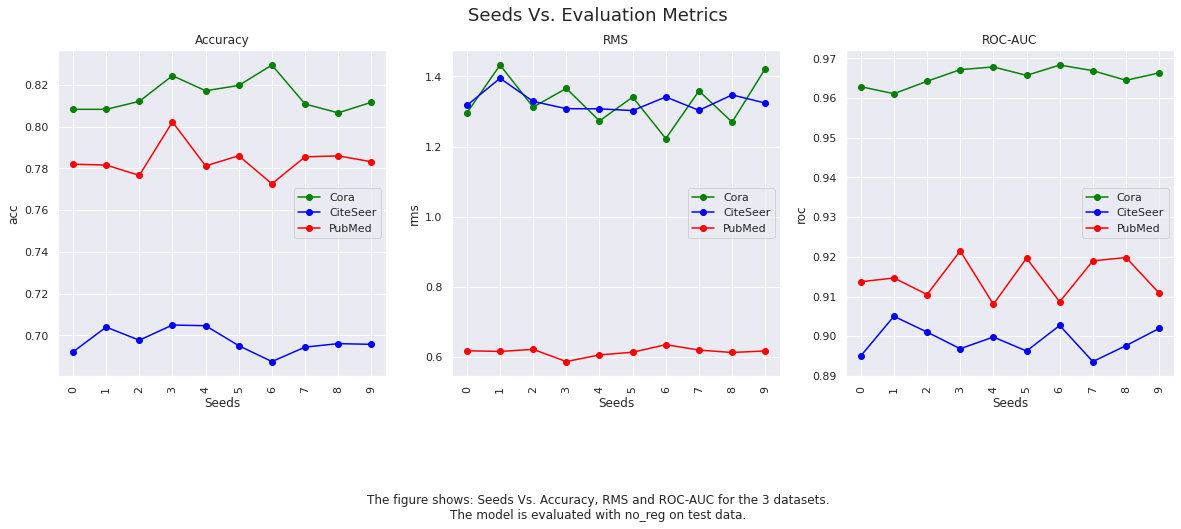

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Seeds on test: 6
    rms best Seeds on test: 6
    roc best Seeds on test: 6
========= CiteSeer:
    acc best Seeds on test: 3
    rms best Seeds on test: 5
    roc best Seeds on test: 1
========= PubMed:
    acc best Seeds on test: 3
    rms best Seeds on test: 3
    roc best Seeds on test: 3


#### Fixed seed with different As and Bs
L03 P02 Q03


In [ ]:
# set parameters
clear()
reg_loss = 'no_reg'
mu = 0
seed = 3
As = [20, 30, 40, 50, 60] 
Bs = np.array(As) + 10

In [ ]:
# train an evaluate
Results, params, params_tag, reg_loss = evaluation(As = As, Bs = Bs, mu = mu, seed = seed, reg_loss = reg_loss)

Training with no_reg with different "Number Training Nodes":
Cora:
0%: A,B= (20,30), val_loss: 0.6434
    Test_acc: 0.8244, Test_rms: 1.3660, Test_roc: 0.9672
40%: A,B= (40,50), val_loss: 0.5466
    Test_acc: 0.8446, Test_rms: 1.3168, Test_roc: 0.9734
80%: A,B= (60,70), val_loss: 0.5637
    Test_acc: 0.8454, Test_rms: 1.2617, Test_roc: 0.9751
CiteSeer:
0%: A,B= (20,30), val_loss: 1.0390
    Test_acc: 0.7050, Test_rms: 1.3082, Test_roc: 0.8969
40%: A,B= (40,50), val_loss: 0.8526
    Test_acc: 0.7169, Test_rms: 1.2289, Test_roc: 0.9132
80%: A,B= (60,70), val_loss: 0.7700
    Test_acc: 0.7322, Test_rms: 1.1971, Test_roc: 0.9198
PubMed:
0%: A,B= (20,30), val_loss: 0.5174
    Test_acc: 0.8023, Test_rms: 0.5866, Test_roc: 0.9215
40%: A,B= (40,50), val_loss: 0.4373
    Test_acc: 0.8151, Test_rms: 0.5817, Test_roc: 0.9354
80%: A,B= (60,70), val_loss: 0.4819
    Test_acc: 0.8058, Test_rms: 0.6042, Test_roc: 0.9294


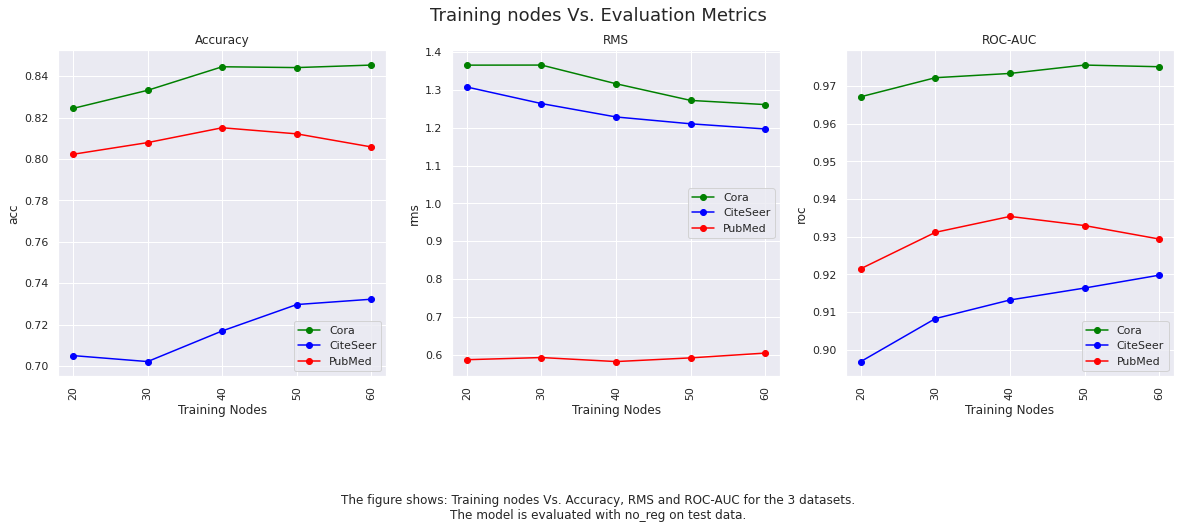

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Training Nodes on test: 60
    rms best Training Nodes on test: 60
    roc best Training Nodes on test: 50
========= CiteSeer:
    acc best Training Nodes on test: 60
    rms best Training Nodes on test: 60
    roc best Training Nodes on test: 60
========= PubMed:
    acc best Training Nodes on test: 40
    rms best Training Nodes on test: 40
    roc best Training Nodes on test: 40


## With P-reg:

#### Original split different Mus 
L03 P02 Q01


In [ ]:
# set parameters
clear()
reg_loss='p_reg'
p_reg_phi = 'cross_entropy'
mus = np.linspace(0,1,21)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(mus=mus, reg_loss=reg_loss, p_reg_phi = p_reg_phi)

Training with p_reg with different "Mus":
Cora:
0%: mu= 0.0000, val_loss: 0.7259
    Test_acc: 0.8080, Test_rms: 1.3161, Test_roc: 0.9680
23%: mu= 0.2500, val_loss: 0.7850
    Test_acc: 0.8250, Test_rms: 1.2787, Test_roc: 0.9695
47%: mu= 0.5000, val_loss: 0.9045
    Test_acc: 0.8370, Test_rms: 1.2381, Test_roc: 0.9682
71%: mu= 0.7500, val_loss: 1.0194
    Test_acc: 0.8380, Test_rms: 1.2280, Test_roc: 0.9676
95%: mu= 1.0000, val_loss: 1.1096
    Test_acc: 0.8350, Test_rms: 1.2284, Test_roc: 0.9676
CiteSeer:
0%: mu= 0.0000, val_loss: 0.9856
    Test_acc: 0.7070, Test_rms: 1.3531, Test_roc: 0.9048
23%: mu= 0.2500, val_loss: 1.0696
    Test_acc: 0.7340, Test_rms: 1.2194, Test_roc: 0.9183
47%: mu= 0.5000, val_loss: 1.1719
    Test_acc: 0.7500, Test_rms: 1.1454, Test_roc: 0.9189
71%: mu= 0.7500, val_loss: 1.2857
    Test_acc: 0.7540, Test_rms: 1.0986, Test_roc: 0.9175
95%: mu= 1.0000, val_loss: 3.1717
    Test_acc: 0.3240, Test_rms: 1.4550, Test_roc: 0.8196
PubMed:
0%: mu= 0.0000, val_loss: 

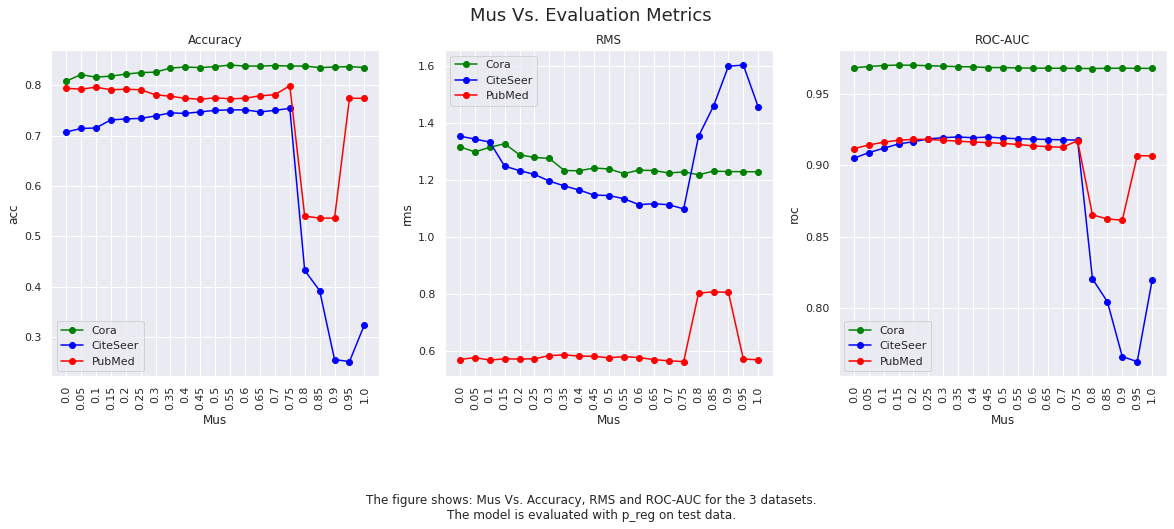

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.55
    rms best Mus on test: 0.8
    roc best Mus on test: 0.15
========= CiteSeer:
    acc best Mus on test: 0.75
    rms best Mus on test: 0.75
    roc best Mus on test: 0.35
========= PubMed:
    acc best Mus on test: 0.75
    rms best Mus on test: 0.75
    roc best Mus on test: 0.2


#### Fixed Seed and Mu with different As and Bs
L03 P02 Q03


In [ ]:
# set parameters
clear()
reg_loss = 'p_reg'
seed = 3
mu = 0.5
As = [20, 30, 40, 50, 60] 
Bs = np.array(As) + 10

In [ ]:
# train an evaluate
Results, params, params_tag, reg_loss = evaluation(As = As, Bs = Bs, mu=mu, seed = seed, reg_loss = reg_loss)

Training with p_reg with different "Number Training Nodes":
Cora:
0%: A,B= (20,30), val_loss: 0.8867
    Test_acc: 0.8172, Test_rms: 1.4364, Test_roc: 0.9648
40%: A,B= (40,50), val_loss: 0.7365
    Test_acc: 0.8503, Test_rms: 1.3242, Test_roc: 0.9727
80%: A,B= (60,70), val_loss: 0.8155
    Test_acc: 0.8465, Test_rms: 1.2555, Test_roc: 0.9737
CiteSeer:
0%: A,B= (20,30), val_loss: 1.3195
    Test_acc: 0.7228, Test_rms: 1.2224, Test_roc: 0.9102
40%: A,B= (40,50), val_loss: 1.1255
    Test_acc: 0.7298, Test_rms: 1.2077, Test_roc: 0.9170
80%: A,B= (60,70), val_loss: 1.0658
    Test_acc: 0.7342, Test_rms: 1.1754, Test_roc: 0.9202
PubMed:
0%: A,B= (20,30), val_loss: 0.8812
    Test_acc: 0.7936, Test_rms: 0.6087, Test_roc: 0.9176
40%: A,B= (40,50), val_loss: 0.7509
    Test_acc: 0.8159, Test_rms: 0.5930, Test_roc: 0.9394
80%: A,B= (60,70), val_loss: 0.7224
    Test_acc: 0.8144, Test_rms: 0.5953, Test_roc: 0.9338


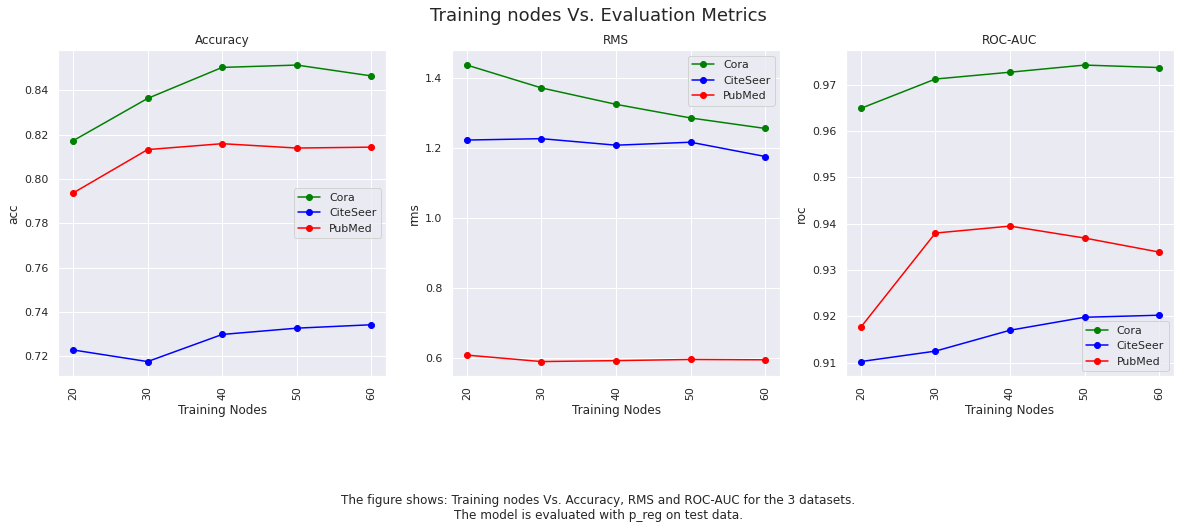

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Training Nodes on test: 50
    rms best Training Nodes on test: 60
    roc best Training Nodes on test: 50
========= CiteSeer:
    acc best Training Nodes on test: 60
    rms best Training Nodes on test: 60
    roc best Training Nodes on test: 60
========= PubMed:
    acc best Training Nodes on test: 40
    rms best Training Nodes on test: 30
    roc best Training Nodes on test: 40


#### Fixed A, B and Mu with different Seeds
L03 P02 Q02


In [ ]:
# set parameters
clear()
reg_loss = 'p_reg'
A        = 20
B        = 30
mu       = 0.5
seeds    = np.arange(10)


In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seeds = seeds, mu=mu, reg_loss=reg_loss)

Training with p_reg with different "Seeds":
Cora:
0%: seed= 0, val_loss: 1.0328
    Test_acc: 0.7943, Test_rms: 1.3044, Test_roc: 0.9583
50%: seed= 5, val_loss: 0.8565
    Test_acc: 0.8210, Test_rms: 1.3501, Test_roc: 0.9641
CiteSeer:
0%: seed= 0, val_loss: 1.3329
    Test_acc: 0.7090, Test_rms: 1.2582, Test_roc: 0.9010
50%: seed= 5, val_loss: 1.4847
    Test_acc: 0.7142, Test_rms: 1.2153, Test_roc: 0.9036
PubMed:
0%: seed= 0, val_loss: 0.9007
    Test_acc: 0.7601, Test_rms: 0.6087, Test_roc: 0.9115
50%: seed= 5, val_loss: 1.0982
    Test_acc: 0.7613, Test_rms: 0.6165, Test_roc: 0.9084


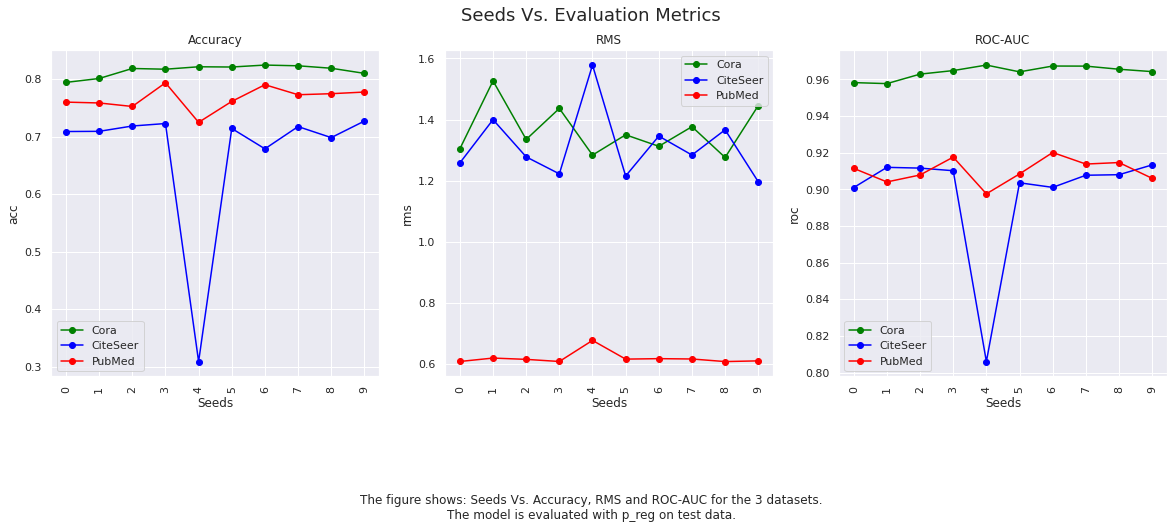

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Seeds on test: 6
    rms best Seeds on test: 8
    roc best Seeds on test: 4
========= CiteSeer:
    acc best Seeds on test: 9
    rms best Seeds on test: 9
    roc best Seeds on test: 9
========= PubMed:
    acc best Seeds on test: 3
    rms best Seeds on test: 8
    roc best Seeds on test: 6


# Aanalysis 02
* Laplacian Regularization, Confidence Penalization, Label Smoothing

#### Lap-Reg
Fixed A, B and Seed with different Mus

In [ ]:
# set parameters
clear()
reg_loss ='lap_reg'
A = 20
B = 30
seed = 0
mus = np.linspace(0,1,21)


In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = 20, B=30, seed = seed, mus=mus, reg_loss = reg_loss)

Training with lap_reg with different "Mus":
Cora:
0%: mu= 0.0000, val_loss: 0.7178
    Test_acc: 0.8083, Test_rms: 1.2959, Test_roc: 0.9629
23%: mu= 0.2500, val_loss: 1.3786
    Test_acc: 0.6938, Test_rms: 1.3696, Test_roc: 0.9372
47%: mu= 0.5000, val_loss: 1.5097
    Test_acc: 0.6612, Test_rms: 1.4043, Test_roc: 0.9349
71%: mu= 0.7500, val_loss: 1.5859
    Test_acc: 0.6412, Test_rms: 1.4026, Test_roc: 0.9335
95%: mu= 1.0000, val_loss: 1.6374
    Test_acc: 0.6047, Test_rms: 1.4639, Test_roc: 0.9327
CiteSeer:
0%: mu= 0.0000, val_loss: 1.0077
    Test_acc: 0.6921, Test_rms: 1.3173, Test_roc: 0.8950
23%: mu= 0.2500, val_loss: 1.3980
    Test_acc: 0.6072, Test_rms: 1.3380, Test_roc: 0.8654
47%: mu= 0.5000, val_loss: 1.5093
    Test_acc: 0.5388, Test_rms: 1.4046, Test_roc: 0.8528
71%: mu= 0.7500, val_loss: 1.5726
    Test_acc: 0.4893, Test_rms: 1.4558, Test_roc: 0.8450
95%: mu= 1.0000, val_loss: 1.6149
    Test_acc: 0.4490, Test_rms: 1.4755, Test_roc: 0.8394
PubMed:
0%: mu= 0.0000, val_loss

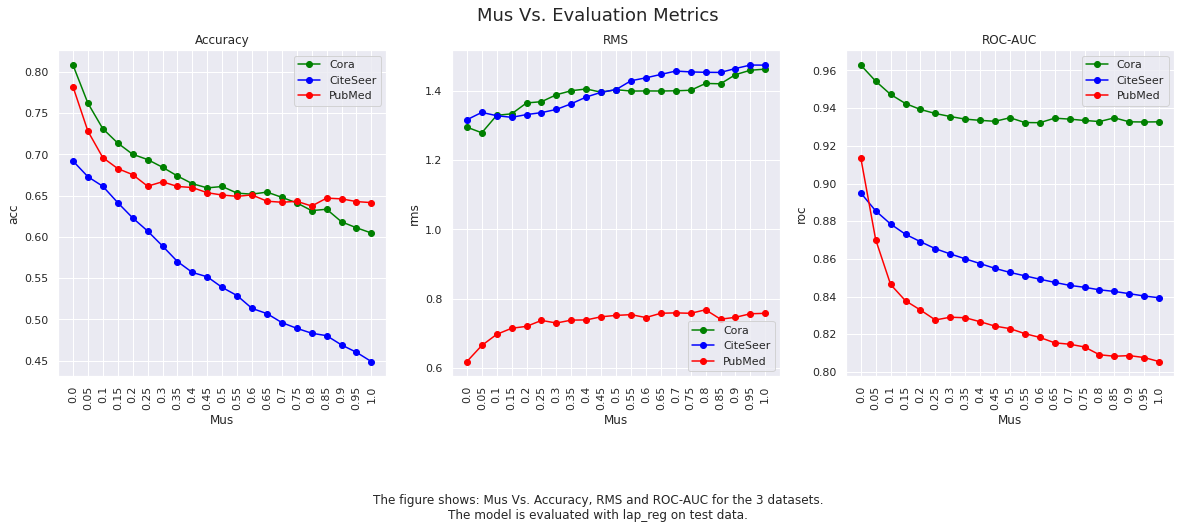

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.0
    rms best Mus on test: 0.05
    roc best Mus on test: 0.0
========= CiteSeer:
    acc best Mus on test: 0.0
    rms best Mus on test: 0.0
    roc best Mus on test: 0.0
========= PubMed:
    acc best Mus on test: 0.0
    rms best Mus on test: 0.0
    roc best Mus on test: 0.0


#### CP-Reg 
Fixed A, B and Seed with different Mus. 

In [ ]:
def cp_loss(Z, beta=-1):
    """
    Confidence Penalty
    See section 5.1:    
    Label smoothing Confidence penalty adds the
    negative entropy of the network outputs to the classification
    loss as a regularizer
    """
    assert beta < 0 , "beta should be negative"
    P = torch.softmax(Z, dim=1)
    neg_entropy  = beta * (P * torch.log(P)).sum(dim=1).mean()  
    return neg_entropy

In [ ]:
# set parameters
clear()
reg_loss ='cp_reg'
A = 20
B = 30
seed = 3
mus = np.linspace(0,1,21)

In [ ]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A=A, B=B,seed = seed, mus=mus, reg_loss = reg_loss)

Training with cp_reg with different "Mus":
Cora:
0%: mu= 0.0000, val_loss: 0.6434
    Test_acc: 0.8244, Test_rms: 1.3660, Test_roc: 0.9672
23%: mu= 0.2500, val_loss: 0.7165
    Test_acc: 0.8295, Test_rms: 1.3744, Test_roc: 0.9677
47%: mu= 0.5000, val_loss: 0.8151
    Test_acc: 0.8227, Test_rms: 1.4211, Test_roc: 0.9652
71%: mu= 0.7500, val_loss: 0.9568
    Test_acc: 0.8104, Test_rms: 1.5015, Test_roc: 0.9615
95%: mu= 1.0000, val_loss: 1.0494
    Test_acc: 0.8053, Test_rms: 1.5315, Test_roc: 0.9600
CiteSeer:
0%: mu= 0.0000, val_loss: 1.0390
    Test_acc: 0.7050, Test_rms: 1.3082, Test_roc: 0.8969
23%: mu= 0.2500, val_loss: 1.1393
    Test_acc: 0.7218, Test_rms: 1.2400, Test_roc: 0.9096
47%: mu= 0.5000, val_loss: 1.2757
    Test_acc: 0.7218, Test_rms: 1.2123, Test_roc: 0.9087
71%: mu= 0.7500, val_loss: 2.7416
    Test_acc: 0.3895, Test_rms: 1.5194, Test_roc: 0.7924
95%: mu= 1.0000, val_loss: 3.0824
    Test_acc: 0.3532, Test_rms: 1.5558, Test_roc: 0.7732
PubMed:
0%: mu= 0.0000, val_loss:

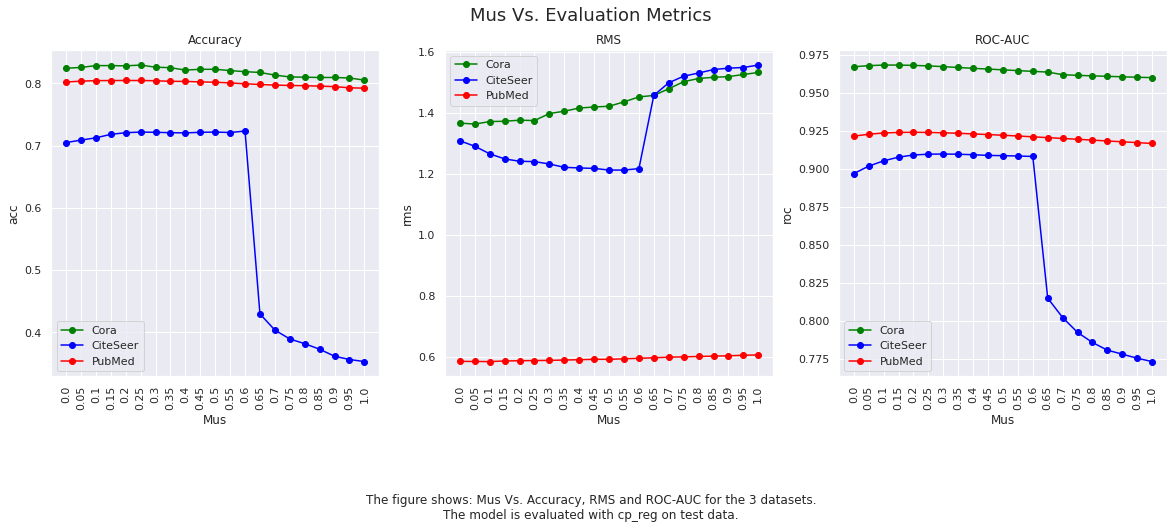

In [ ]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [ ]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.25
    rms best Mus on test: 0.05
    roc best Mus on test: 0.15
========= CiteSeer:
    acc best Mus on test: 0.6
    rms best Mus on test: 0.5
    roc best Mus on test: 0.3
========= PubMed:
    acc best Mus on test: 0.2
    rms best Mus on test: 0.1
    roc best Mus on test: 0.2


#### Label Smoothing
Fixed A, B and Seed with different Mus.

# Figure 3

In [72]:
def TSNE_Runs(dataset_Name, reg_mu = 0.5):
    # init storages  
    Results_lst = []
    subtitles = []

    # init 1st run
    """ set sub_title """
    subtitles.append("GCN")

    """ evaluate """ 
    Results, _ , _ , _ = evaluation(
                                datasets = [dataset_Name], 
                                mu = 0, 
                                seed = 3, 
                                reg_loss = 'no_reg', 
                                verbose = False
                            )
    Results_lst.append(Results)


    # init 2nd run
    """ set sub_title """
    subtitles.append(f"GCN + P-reg (µ = {reg_mu})")

    """ evaluate """ 
    Results, _ , _ , _ = evaluation(datasets = [dataset_Name], 
                                mu = reg_mu, 
                                seed = 3, 
                                reg_loss = 'p_reg', 
                                p_reg_phi = 'cross_entropy',
                                verbose = False 
                            )
    Results_lst.append(Results)

    # init 3rd run 
    """ set sub_title """
    subtitles.append(f"GCN + Laplacian-reg (µ = {reg_mu})")

    """ evaluate """
    Results, _ , _ , _ = evaluation(datasets = [dataset_Name], 
                                mu = mu, 
                                seed = 3, 
                                reg_loss = 'lap_reg', 
                                verbose = False 
                            )
    Results_lst.append(Results)

    return Results_lst, subtitles, dataset_Name

In [73]:
# TSNE_Report Function to plot figure 03 from the paper
def TSNE_Report(Results_lst, subtitles, dataset_Name):    
    # check input 
    assert len(Results_lst) == 3, "Results_lst should have 3 values"
    assert len(subtitles) == 3, "subtitles should have 3 values"
    assert dataset_Name in ['Cora', 'CiteSeer', 'PubMed'], "check dataset_Name"

    # from list to dict
    Results_lst = [Results_lst[x] for x in range(len(Results_lst))]
    
    # load dataset
    dataset = load_dataset(dataset_Name)

    # Set figure params
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(f"{dataset_Name} - TSNE visualization of embeddings on Test data", fontsize=18);
    for i, Results in enumerate(Results_lst): 
        # get Z, test_mask 
        Z = Results[f'{dataset_Name}_Z'][0]
        test_mask = Results[f'{dataset_Name}_test_mask'][0]

        # TSNE Embedding
        transform = TSNE  # or PCA
        trans = transform(n_components=2, init='pca', learning_rate='auto')
        X_reduced = trans.fit_transform(Z[test_mask,:].detach().cpu().numpy())

        # Plot
        axs[i].scatter(
            X_reduced[:, 0],
            X_reduced[:, 1],
            c = dataset[0].y[test_mask],
            cmap = "jet",
            alpha = 0.7,
        )
        axs[i].set(
            xlabel = "$X_1$",
            ylabel = "$X_2$",
            title = subtitles[i]
        )
        
    caption =   f"The t-SNE visualization of GCN outputs " \
                f"on the {dataset_Name} test dataset (best viewed in color)." 
    plt.figtext(0.5, -0.2, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

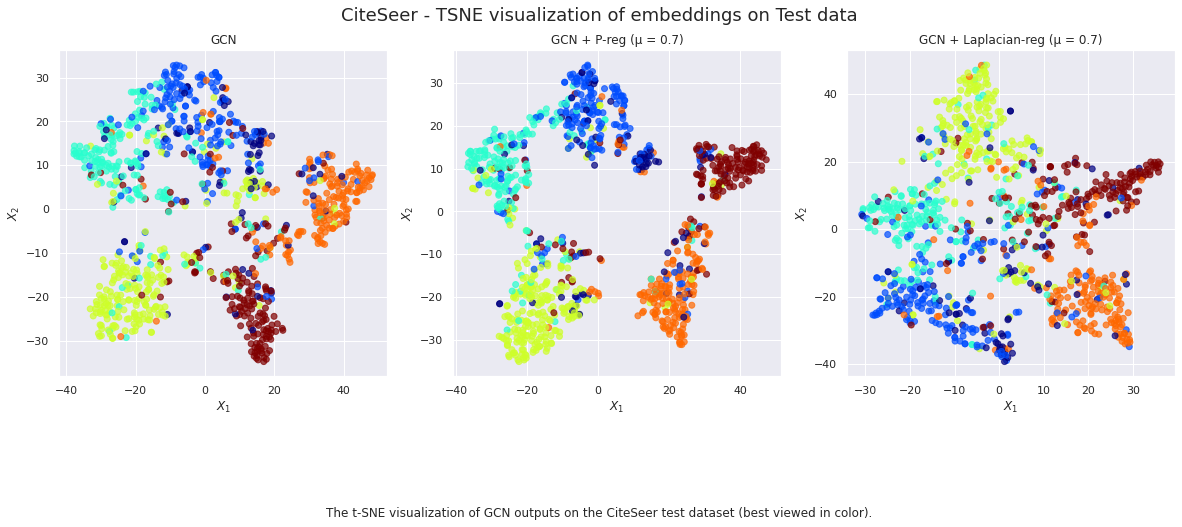

In [74]:
TSNE_Report(*TSNE_Runs('CiteSeer', reg_mu = 0.7))

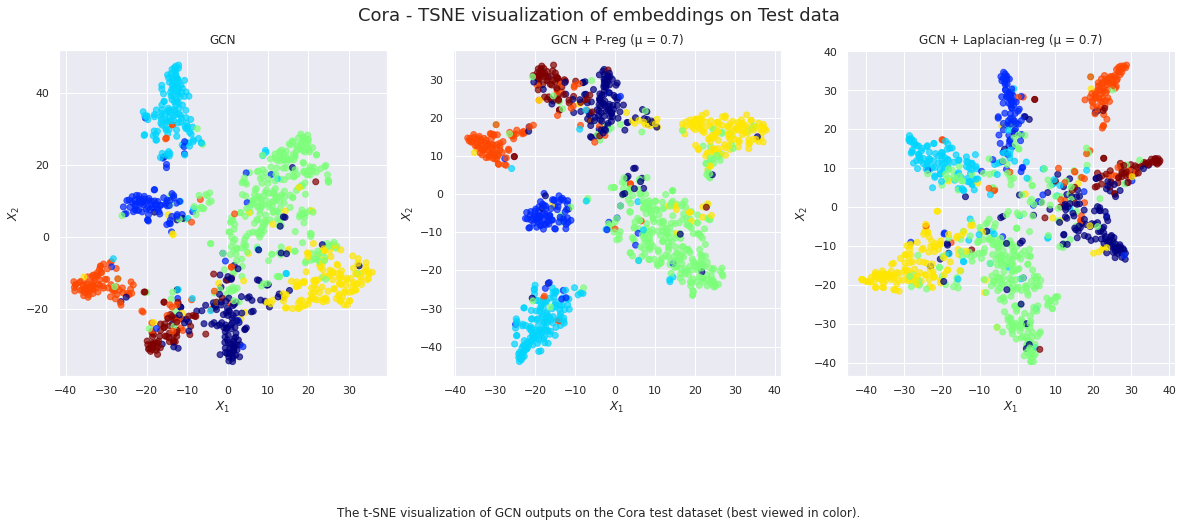

In [75]:
TSNE_Report(*TSNE_Runs('Cora', reg_mu = 0.7))

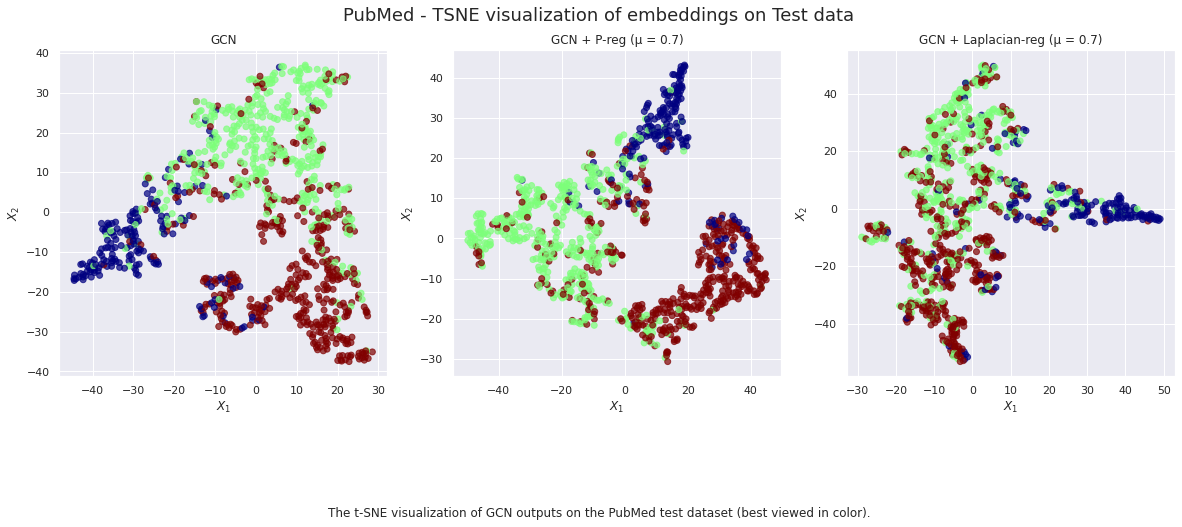

In [76]:
TSNE_Report(*TSNE_Runs('PubMed', reg_mu = 0.7))